# Multioutput Gaussian process example

## Usage notes
This toolkit works in the following order:- Set up the input data
- Create model (SM, MOSM, CSM, SM-LMC, CG)
- Make an estimation of the model parameters using BNSE+SM
- Train the model parameters
- Set the prediction range
- Do a prediction For example:

#### Imports and plot format

In [1]:
# execute if not installed
import sys
import os
sys.path.insert(0, '../')

import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

In [2]:
os.makedirs('output', exist_ok=True)

# Air Quality MOGP

Experiment on multioutput ussing the mogptk toolbox.

The dataset hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device.

The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses.

We will use the columns: $1, 3, 4, 6, 8$.
Where 200 hours of measurements were used ($\approx 8.3$ days), starting from the 12th day.

2. __CO(GT)__ True hourly averaged concentration CO in mg/m^3 (reference analyzer)
3. __PT08.S1(CO)__ PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
4. __NMHC(GT)__ True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
5. __C6H6(GT)__ True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
6. __PT08.S2(NMHC)__ PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
7. __NOx(GT)__ True hourly averaged NOx concentration in ppb (reference analyzer)
8. __PT08.S4(NO2)__ PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
9. __NO2(GT)__ True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
10. __PT08.S4(NO2)__ PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
11. __PT08.S5(O3)__ PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
12. __T__ Temperature in Â°C
13. __RH__ Relative Humidity (%)
14. __AH__ AH Absolute Humidity 

__Load and Pre-processing__

In [10]:
# load
df = pd.read_csv('data/AirQualityUCI.csv', delimiter=';')

# last 2 columns are only nans
df = df.iloc[:, :-2]

# drop the rows with nan values
df.dropna(inplace=True)

# First 2 columns are date and time, we convert it to a single column with datetime format
dates = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')

# create column with datetime values
df['timedate'] = dates

# define a initial date to compare all other to
ini_date = pd.Timestamp('2004-03-10 00:00:00.0')

# get elapsed hours
df['time'] = (dates - ini_date) / pd.Timedelta(hours=1)

# drop useless columns
df.drop(columns=['Time', 'Date'], inplace=True)

df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,timedate,time
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00,18.0
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00,19.0
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00,20.0
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00,21.0
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00,22.0


We check the number of missing values per column, registered as -200 (minimun value of the sensor)

In [11]:
(df == -200).sum(0)

CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
timedate            0
time                0
dtype: int64

## Data to use

* As outputs we will use the ground thruth of: CO, NMHC, C6H6, NOx, NO2.
* Only time is used as input.

**For this we will use the mogptk.Data class, which allows to use the different models in the toolbox.**

In [12]:
# we use the first 200 rows, the first 8 days
n_experiment = 200
ini_t = 300
df2 = df.iloc[ini_t:n_experiment + ini_t]

In [13]:
# columns to use
cols = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

# class for storing data
data = []


for i, c in enumerate(cols):
    # index of non-missing values
    idx = (df2[c] != -200)
    
    print('Channel {} with {} non-missing values'.format(c, idx.sum()))
    
    # add data to the model
    x = df2['time'][idx].values
    y = np.log(df2[c][idx].values)
    
    data.append(mogptk.Data(x, y))

Channel CO(GT) with 196 non-missing values
Channel NMHC(GT) with 200 non-missing values
Channel C6H6(GT) with 200 non-missing values
Channel NOx(GT) with 192 non-missing values
Channel NO2(GT) with 192 non-missing values


__Remove random portions of the data to simulate sensor failure__

In [14]:
# randomly sample from the data
for channel in data:
    channel.remove_randomly(pct=0.7)

# drop chunks to simulate sensor failure
channel.remove_range(425, 460)
channel.remove_range(480, None)
channel.remove_range(480, None)
channel.remove_range(480, None)
channel.remove_range(None, 350)

In [15]:
x_test = [channel.X[~channel.mask] for channel in data]

y_test = [channel.Y[~channel.mask] for channel in data]

__Function for plotting the experiment__

# 1. Independant GP with SM kernel (IGP)

As a first approach, we model the 5 mesurement as independent Gaussian processes, each one with a Spectral mixture kernel of $Q=5$ components.

In [16]:
%%time
# Spectral Mixture kernel
Q = 5 # number of mixtures
n_cols = len(data)

igp_list = []

# metric containers
igp_mae = np.zeros(n_cols)
igp_nmae = np.zeros(n_cols)
igp_rmse = np.zeros(n_cols)
igp_nrmse = np.zeros(n_cols)

for i in range(5):
    # first get the sm kernel params set
    model = mogptk.SM(data[i], Q=Q)
    model.init_params('BNSE')
    
    model.build()
    model.train(method='L-BFGS-B', maxiter=3000, tol=1e-30)
    igp_list.append(model)
    
    # predict
    x, mean, var = model.predict(x_pred)
    
    error = mogptk.test_errors(model, x_test=[x_test[i]], y_test=[y_test[i]])
    
    igp_mae[i] = np.array(error[0])[:, 0]
    igp_nmae[i] = np.array(error[0])[:, 1]
    igp_rmse[i] = np.array(error[0])[:, 2]
    igp_nrmse[i] = np.array(error[0])[:, 3]

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 44.246821
  Number of iterations: 2705
  Number of functions evaluations: 3095
Done in  0.09693631331125895  minutes
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 66.452699
  Number of iterations: 352
  Number of functions evaluations: 527
Done in  0.020846811930338542  minutes
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 41.845531
  Number of iterations: 445
  Number of functions evaluations: 533
Done in  0.022557870546976725  minutes
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 44.490406
  Number of iterations: 46
  Number of functions evaluations: 97
Done in  0.008350197474161785  minutes
INFO:tensorflow:Optimizatio

In [17]:
pd.DataFrame(np.c_[igp_mae, igp_nmae, igp_rmse, igp_nrmse],
             columns=['MAE', 'nMAE', 'RMSE', 'nRMSE'],
             index=cols)

,MAE,nMAE,RMSE,nRMSE
CO(GT),0.453405,0.893172,0.537562,1.058953
NMHC(GT),0.584602,0.123143,0.717336,0.151102
C6H6(GT),0.385563,0.213691,0.511959,0.283743
NOx(GT),0.375592,0.081819,0.482373,0.105080
NO2(GT),0.239398,0.053233,0.310363,0.069013


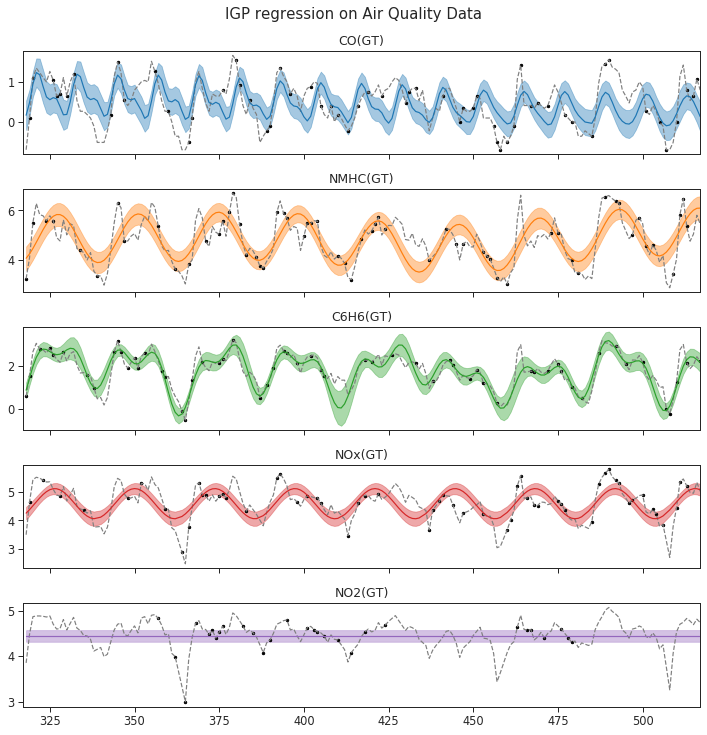

In [18]:
f, axarr = plt.subplots(5, 1, sharex=True, figsize=(10, 10))
axarr = axarr.reshape(-1)

for i in range(len(cols)):
    c = igp_list[i].data[0]
    x_train = c.X[c.mask]
    y_train = mogptk.data._detransform(c.transformations, c.X[c.mask], c.Y[c.mask])
    
    x_all = c.X
    y_all = mogptk.data._detransform(c.transformations, c.X, c.Y)
    
    x_pred = c.X
    mean_pred, lower_ci, upper_ci = igp_list[i].predict([x_pred])
    
    axarr[i].plot(x_train[:, 0], y_train, '.k', label='Train', )
    axarr[i].plot(x_all[:, 0], y_all, '--', label='Test', c='gray')

    axarr[i].plot(x_pred[:, 0], mean_pred[0], label='Post.Mean', c=sns.color_palette()[i%10])
    axarr[i].fill_between(x_pred[:, 0].reshape(-1),
                          lower_ci[0],
                          upper_ci[0],
                          label='95% c.i',
                          color=sns.color_palette()[i%10],
                          alpha=0.4)

    axarr[i].set_xlim(x_all[0]-1, x_all[-1])

    # set channels name
    
    axarr[i].set_title(cols[i])

plt.suptitle('IGP regression on Air Quality Data', y=1.02)
plt.tight_layout()

# 2. Multioutput Spectral Mixture (MOSM)

Next we use the multioutput spectral mixture (Parra et al, 2016) to model the measurements

In [19]:
model_mosm = mogptk.MOSM(data, Q=4)
model_mosm.init_params('BNSE')
model_mosm.build()

__Optimice__

In [20]:
%%time
model_mosm.train(method='L-BFGS-B', maxiter=3000, tol=1e-15)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -10.114062
  Number of iterations: 3000
  Number of functions evaluations: 3194
Done in  5.837903078397115  minutes
CPU times: user 7min 16s, sys: 34.7 s, total: 7min 51s
Wall time: 5min 50s


__Predict on all hours and plot__

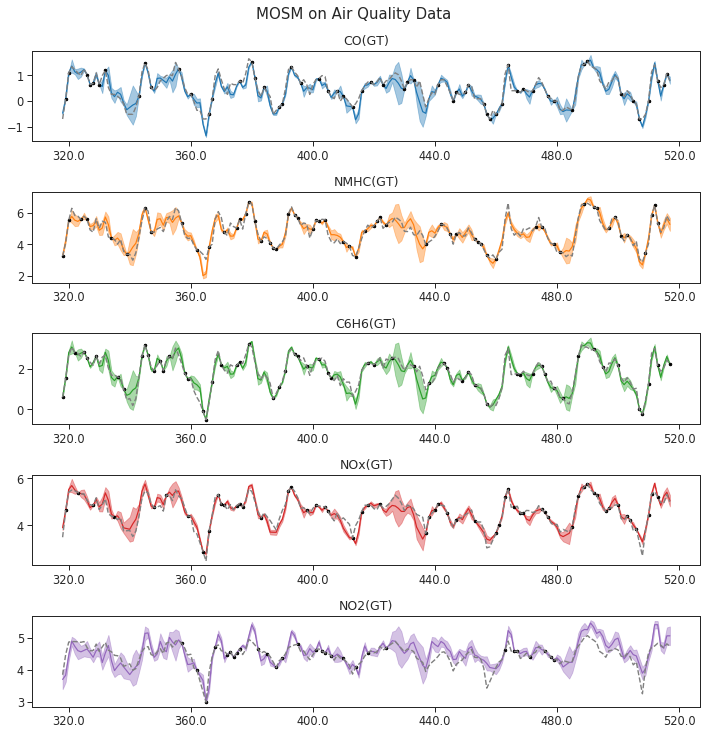

In [21]:
model_mosm.plot_prediction(grid=(5, 1), figsize=(10, 10), title='MOSM on Air Quality Data', names=cols)

### Get error metrics per channel

In [22]:
error = mogptk.test_errors(model_mosm, x_test=x_test, y_test=y_test)

pd.DataFrame(np.c_[np.array(error[0])[:, 0],
                   np.array(error[0])[:, 1],
                   np.array(error[0])[:, 2],
                   np.array(error[0])[:, 3]
                  ],
             columns=['MAE', 'nMAE', 'RMSE', 'nRMSE'],
             index=cols)

,MAE,nMAE,RMSE,nRMSE
CO(GT),0.173233,0.341256,0.236076,0.465050
NMHC(GT),0.311994,0.065719,0.392247,0.082624
C6H6(GT),0.214339,0.118793,0.292477,0.162099
NOx(GT),0.194586,0.042389,0.254463,0.055432
NO2(GT),0.205854,0.045774,0.264787,0.058879


# 3. Cross Spectral Mixture (CSM)

Then we use the cross spectral mixture kernel (Ulrich et al, 2015)

In [23]:
model_csm = mogptk.CSM(data, Q=4)
model_csm.init_params()
model_csm.build()

In [24]:
model_csm.train(method='L-BFGS-B', maxiter=3000, tol=1e-15)

INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 49.925749
  Number of iterations: 1640
  Number of functions evaluations: 1776
Done in  1.5990325808525085  minutes


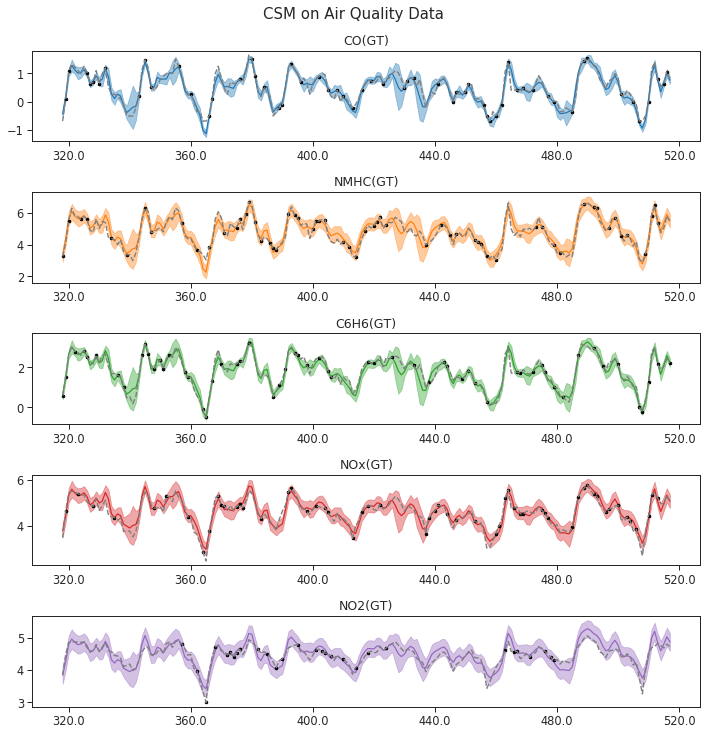

In [25]:
model_csm.plot_prediction(grid=(5, 1), figsize=(10, 10), title='CSM on Air Quality Data', names=cols)

In [26]:
error = mogptk.test_errors(model_csm, x_test=x_test, y_test=y_test)

pd.DataFrame(np.c_[np.array(error[0])[:, 0],
                   np.array(error[0])[:, 1],
                   np.array(error[0])[:, 2],
                   np.array(error[0])[:, 3]
                  ],
             columns=['MAE', 'nMAE', 'RMSE', 'nRMSE'],
             index=cols)

,MAE,nMAE,RMSE,nRMSE
CO(GT),0.140791,0.277347,0.191080,0.376413
NMHC(GT),0.272854,0.057475,0.344112,0.072485
C6H6(GT),0.185661,0.102899,0.252342,0.139855
NOx(GT),0.175599,0.038252,0.227301,0.049515
NO2(GT),0.136135,0.030271,0.169479,0.037686


# 4. Spectral Mixture - Linear Model of Corregionalization (SM-LMC)

Lastly we fit the Spectral mixture- linear model of corregionalization (Wilson, 2014)

In [27]:
model_smlmc = mogptk.SM_LMC(data, Q=4)
model_smlmc.init_params()
model_smlmc.build()

In [28]:
model_smlmc.train(method='L-BFGS-B', maxiter=3000, tol=1e-15)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 28.906932
  Number of iterations: 3000
  Number of functions evaluations: 3196
Done in  1.8337441762288411  minutes


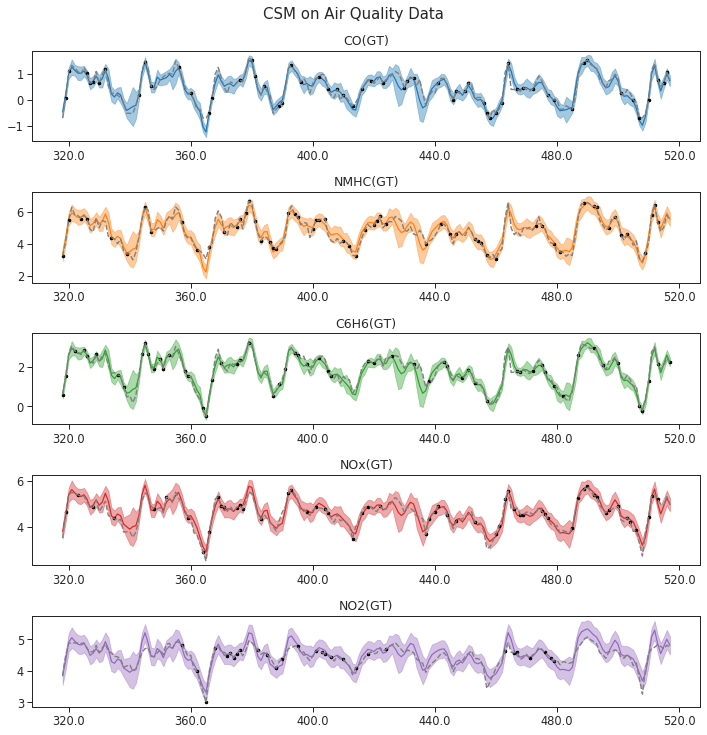

In [29]:
model_smlmc.plot_prediction(grid=(5, 1), figsize=(10, 10), title='CSM on Air Quality Data', names=cols)

In [30]:
error = mogptk.test_errors(model_smlmc, x_test=x_test, y_test=y_test)

pd.DataFrame(np.c_[np.array(error[0])[:, 0],
                   np.array(error[0])[:, 1],
                   np.array(error[0])[:, 2],
                   np.array(error[0])[:, 3]
                  ],
             columns=['MAE', 'nMAE', 'RMSE', 'nRMSE'],
             index=cols)

,MAE,nMAE,RMSE,nRMSE
CO(GT),0.140724,0.277215,0.196780,0.387641
NMHC(GT),0.272379,0.057375,0.344858,0.072642
C6H6(GT),0.183992,0.101974,0.255312,0.141501
NOx(GT),0.168547,0.036716,0.221726,0.048301
NO2(GT),0.136408,0.030332,0.174230,0.038742


# 5. Convolutional Gaussian (CONV)

In [31]:
model_conv = mogptk.CG(data, Q=4)
model_conv.init_params()
model_conv.build()

         Current function value: 45.325481
         Iterations: 89
         Function evaluations: 103
         Gradient evaluations: 102
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: 45.325481
  Number of iterations: 89
  Number of functions evaluations: 103
Done in  0.008522121111551921  minutes
         Current function value: 72.671685
         Iterations: 51
         Function evaluations: 130
         Gradient evaluations: 119
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: 72.671685
  Number of iterations: 51
  Number of functions evaluations: 130
Done in  0.009120512008666991  minutes
         Current function value: 77.830735
         Iterations: 33
         Function evaluations: 128
         Gradient evaluations: 117
INFO:tensorflow:Optimization terminated with:
  Message: Desired 

In [32]:
model_conv.train(method='L-BFGS-B', maxiter=3000, tol=1e-15)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 225.644055
  Number of iterations: 1876
  Number of functions evaluations: 2156
Done in  2.1032660722732546  minutes


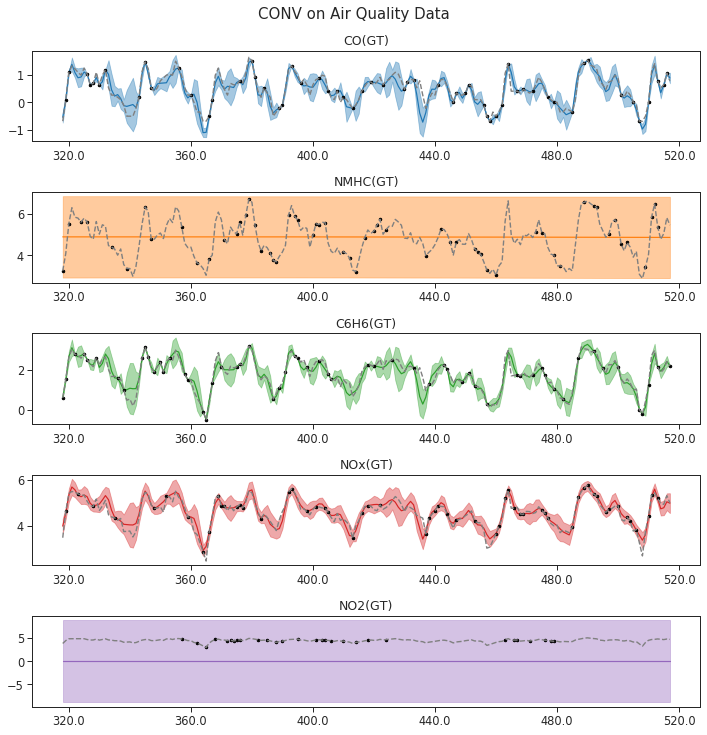

In [33]:
model_conv.plot_prediction(grid=(5, 1), figsize=(10, 10), title='CONV on Air Quality Data', names=cols)

In [34]:
error = mogptk.test_errors(model_conv, x_test=x_test, y_test=y_test)

pd.DataFrame(np.c_[np.array(error[0])[:, 0],
                   np.array(error[0])[:, 1],
                   np.array(error[0])[:, 2],
                   np.array(error[0])[:, 3]
                  ],
             columns=['MAE', 'nMAE', 'RMSE', 'nRMSE'],
             index=cols)

,MAE,nMAE,RMSE,nRMSE
CO(GT),0.165398,0.325821,0.233373,0.459726
NMHC(GT),0.702306,0.147936,0.870271,0.183317
C6H6(GT),0.205762,0.114039,0.307079,0.170192
NOx(GT),0.173297,0.037751,0.236214,0.051457
NO2(GT),4.497175,1.000000,4.507547,1.002306
